VISUALIZE LITERATURE DATASET- PREPROCESSED NORMALISED IMAGES FROM CAXTON DATASET USING DATASET MODULE CLASS

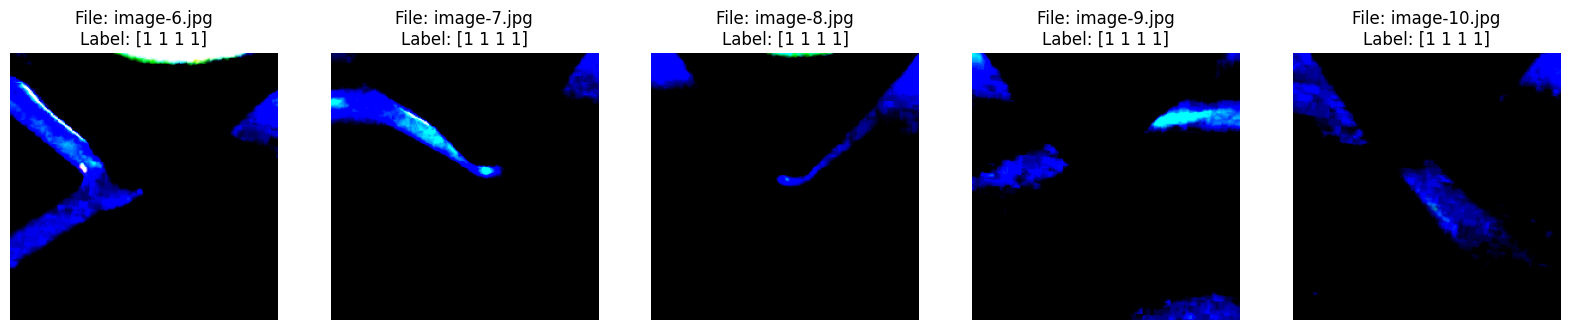

In [15]:
import os
import torch
import pandas as pd
from data.data_module import ParametersDataModule
from matplotlib import pyplot as plt

# Define paths to your data directory and CSV file
data_dir = r'C:\Users\Swornava\OneDrive - Delft University of Technology\CORE\CAXTON DATASET'
csv_file = r'C:\Users\Swornava\OneDrive - Delft University of Technology\CORE\CAXTON DATASET\test.csv'

# Define data module parameters
batch_size = 20
dataset_name = 'CAXTON_DATASET'
mean = [0.2925814, 0.2713622, 0.14409496]  # Mean for normalization 
std = [0.0680447, 0.06964592, 0.0779964]   # Std for normalization 

# Initialize the data module
data_module = ParametersDataModule(
    batch_size=batch_size,
    data_dir=data_dir,
    csv_file=csv_file,
    dataset_name=dataset_name,
    mean=mean,
    std=std,
    load_saved=False,
    transform=True
)

# Prepare the data
data_module.setup(stage="fit")

# Create data loader
train_loader = data_module.train_dataloader()

# Load the CSV file
df = pd.read_csv(csv_file)

# Visualize some samples from the dataset
def visualize_batch(batch, df, batch_size):
    images, labels = batch
    image_indices = range(len(images))  # Get the indices for the batch
    image_filenames = df['img_path'].values[:batch_size]  # Extract image paths from the CSV
    fig, axs = plt.subplots(1, len(images), figsize=(20, 5))

    for i, (img, label) in enumerate(zip(images, labels)):
        img = img.permute(1, 2, 0)  # Permute to (H, W, C) format for plotting
        #img = img * torch.tensor(std) + torch.tensor(mean)  # Denormalize
        img = img.clamp(0, 1)  # Ensure pixel values are in [0, 1]
        axs[i].imshow(img)
        axs[i].set_title(f"File: {os.path.basename(image_filenames[i])}\nLabel: {label.numpy()}")
        axs[i].axis('off')
    plt.show()

# Get a batch of data
batch = next(iter(train_loader))

# Visualize the batch along with the filenames from the CSV
visualize_batch(batch, df, batch_size)

DATA PREPARATION:
1. INCREASE IMAGE BRIGHTNESS AND SAVE IN DIRECTORY (NOTE THE PROTOTYPE NAMES CAREFULLY)

2. Path of the image also changed in the csv for workability

3. Some Images were filtered - start and end of printing; and ones that donot have a coresponding data row in the csv file


In [40]:
import os
import pandas as pd
from shutil import move
from PIL import Image, ImageEnhance

# Function to increase brightness, rename images, and update CSV
def process_images_and_update_csv(image_folder, csv_path, output_folder, new_csv_path, brightness_factor=1.5):
    # Load the CSV file
    df = pd.read_csv(csv_path)

    # Keep the column names intact, remove the next 4 rows (i.e., the first four images) #CHANGEE BASED ON HOW MANY TO FILTER
    df = df.drop(df.index[0:6]).reset_index(drop=True)

    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterate through the remaining images, enhance brightness, rename, and update CSV
    for index, row in df.iterrows():
        # Skip the first row as it's the header
        
        old_image_path = os.path.join(image_folder, os.path.basename(row['photo_location']))
        new_image_name = f"C5c_{index:03d}.jpg"
        new_image_path = os.path.join(output_folder, new_image_name)

        # Open, increase brightness, and save the image
        if os.path.exists(old_image_path):
            with Image.open(old_image_path) as img:
                enhancer = ImageEnhance.Brightness(img)
                img_bright = enhancer.enhance(brightness_factor)
                img_bright.save(new_image_path)

        # Update the photo_location in the dataframe
        df.at[index, 'photo_location'] = f"dataset_filtered/{new_image_name}"

    # Save the updated CSV to the new path
    df.to_csv(new_csv_path, index=False)

    print(f"Images processed, renamed, and CSV updated. New CSV saved at {new_csv_path}")

# USAGE
image_folder = r'C:\Users\Swornava\Delft University of Technology\Wei Wei - MSc3_CORE_Group 2\Dataset\Prototype V2\20241024\2024-10-24-11-26-18_C5-3' #CHANGE
csv_path = r'C:\Users\Swornava\Delft University of Technology\Wei Wei - MSc3_CORE_Group 2\Dataset\Prototype V2\20241024\2024-10-24-11-26-18_C5-3\2024-10-24-11-26-18_dataset.csv' #CHANGE
output_folder = r'E:\MSC\CORE\MudTracker3D\mudtracker3d_dataset\dataset filtered'  #REMAINS SAME
new_csv_path = r'E:\MSC\CORE\MudTracker3D\mudtracker3d_dataset\C5c.csv' #CHANGE
brightness_factor = 1.5  # Adjust brightness factor 

process_images_and_update_csv(image_folder, csv_path, output_folder, new_csv_path, brightness_factor)



Images processed, renamed, and CSV updated. New CSV saved at E:\MSC\CORE\MudTracker3D\mudtracker3d_dataset\C5c.csv


In [2]:
import os
from PIL import Image, ImageEnhance

# Function to crop and resize images using the center point as the crop center
def crop_and_resize_images(input_folder, target_resolution=(1280, 720), center_point=(2291, 1039)):
    # Iterate over all files in the input folder
    for filename in os.listdir(input_folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            file_path = os.path.join(input_folder, filename)

            # Open the image
            with Image.open(file_path) as img:
 
                #BRIGHTNESS
                #brightness_factor=1.7
                #enhancer = ImageEnhance.Brightness(img)
                #img = enhancer.enhance(brightness_factor)
 
                # Original resolution
                width, height = img.size

                # Define the cropping box around the center point (x, y)
                target_width, target_height = target_resolution

                # Calculate the left, top, right, and bottom based on the center point
                left = center_point[0] - target_width // 2
                top = center_point[1] - target_height // 2
                right = center_point[0] + target_width // 2
                bottom = center_point[1] + target_height // 2

                # Ensure the crop box stays within the image boundaries
                if left < 0:
                    left = 0
                    right = target_width
                if right > width:
                    right = width
                    left = width - target_width
                if top < 0:
                    top = 0
                    bottom = target_height
                if bottom > height:
                    bottom = height
                    top = height - target_height

                # Crop the image
                cropped_img = img.crop((left, top, right, bottom))

                # Resize the cropped image to the target resolution
                resized_img = cropped_img.resize(target_resolution, Image.Resampling.LANCZOS)


                # Save and overwrite the original image
                resized_img.save(file_path)



                print(f"Processed and overwritten: {filename}")

# Define paths and center point
input_folder = r'C:\Users\Swornava\Delft University of Technology\Wei Wei - MSc3_CORE_Group 2\Test_print\test_print_photo\Image_detection'  # Change this to the path of your image folder
center_point = (1163, 735)  # x, y center point in pixels

# Process images
crop_and_resize_images(input_folder, target_resolution=(1280, 720), center_point=center_point)


Processed and overwritten: 3-Cc.jpg
Processed and overwritten: 7.jpg


2. MODIFYING THE CSV FILE: Turn G-code into readable data

-G-code string to Data-Parameters: x, y, z, extrusion_e, and speed_f

-Append nozzle_tip_x and nozzle_tip_y to the csv by locating the nozzle tip of an image manually on paint

-Edit extrusion rate???


In [39]:
import pandas as pd 
import re

# Function to extract G-code data and modify the CSV
def extract_gcode_and_modify_csv(input_csv, output_csv):
    # Load the CSV file
    df = pd.read_csv(input_csv)

    # Rename 'photo_location' column to 'img_path'
    df.rename(columns={'photo_location': 'img_path'}, inplace=True)

    # Regular expression pattern to extract x, y, z, e, and f values
    pattern = r'G\d+\sX(-?\d*\.?\d+)\sY(-?\d*\.?\d+)?\sZ(-?\d*\.?\d+)?\sE(-?\d*\.?\d+)?\sF(\d+)?'

    # Create new columns for x, y, z, extrusion_e, and speed_f
    df[['x', 'y', 'z', 'extrusion_e', 'speed_f']] = df['gcode'].str.extract(pattern)

    # Convert the extracted values to numeric type
    df['x'] = pd.to_numeric(df['x'], errors='coerce')
    df['y'] = pd.to_numeric(df['y'], errors='coerce')
    df['z'] = pd.to_numeric(df['z'], errors='coerce')
    df['extrusion_e'] = pd.to_numeric(df['extrusion_e'], errors='coerce')
    df['speed_f'] = pd.to_numeric(df['speed_f'], errors='coerce')

    # Append nozzle_tip_x and nozzle_tip_y columns with constant values   CHANGE
    df['nozzle_tip_x'] = 638
    df['nozzle_tip_y'] = 357

    df['extrusion_class'] = 2
    df['layer_height_class'] = 2

    # Calculate the layer height as the difference in 'z' between consecutive rows
    df['layer_height'] = 1.2   #CHANGE

    # Append the extrusion_rate column with a constant value of 0.2 for all rows
    df['extrusion_rate'] = 1.0  #CHANGE

    # Reorder the columns so that 'extrusion_rate' comes right after 'extrusion_e'
    columns_order = ['img_path', 'timestamp', 'x', 'y', 'z', 'layer_height', 'extrusion_e', 'extrusion_rate', 
                     'speed_f', 'nozzle_tip_x', 'nozzle_tip_y', 'layer_height_class', 'extrusion_class']

    # Reorder the DataFrame with the new column order
    df = df[columns_order]

    # Drop the original 'gcode' column
    df = df.drop(columns=['gcode'], errors='ignore')  # 'gcode' might already be dropped in case of re-runs

    # Save the modified DataFrame to a new CSV file
    df.to_csv(output_csv, index=False)

    print(f"CSV file updated and saved to {output_csv}")

# Usage
input_csv = r'E:\MSC\CORE\MudTracker3D\mudtracker3d_dataset\C5c.csv'  
output_csv = r'E:\MSC\CORE\MudTracker3D\mudtracker3d_dataset\C5c_modified.csv'  

extract_gcode_and_modify_csv(input_csv, output_csv)


CSV file updated and saved to E:\MSC\CORE\MudTracker3D\mudtracker3d_dataset\C5c_modified.csv


JOIN ALL CSVS

In [79]:
import os
import pandas as pd

# Specify the folder containing the CSV files
folder_path = r'E:\MSC\CORE\MudTracker3D\mudtracker3d_dataset\modified_csvs'
output_file = r'E:\MSC\CORE\MudTracker3D\mudtracker3d_dataset\modified_csvs\final_dataset_full_filtered.csv'

# Initialize an empty list to store DataFrames
dataframes = []

# Loop through all the CSV files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_csv(file_path)
        dataframes.append(df)

# Concatenate all DataFrames into one
merged_df = pd.concat(dataframes, ignore_index=True)

# Save the merged DataFrame to a CSV file
merged_df.to_csv(output_file, index=False)

print(f"All files merged and saved to {output_file}")

All files merged and saved to E:\MSC\CORE\MudTracker3D\mudtracker3d_dataset\modified_csvs\final_dataset_full_filtered.csv


In [83]:
#CHECK MISSING IMAGES

import os
import pandas as pd

# Specify the paths
csv_file = r'E:\MSC\CORE\MudTracker3D\mudtracker3d_dataset\dataset_full_filtered.csv'  # Your merged CSV file
image_folder = r'E:\MSC\CORE\MudTracker3D\mudtracker3d_dataset\dataset filtered\dataset_filtered'  # Folder containing images

# Read the CSV file
df = pd.read_csv(csv_file)

# Get the list of image paths from the CSV
image_paths_in_csv = df['img_path'].tolist()

# Get the list of image files present in the folder
images_in_folder = set(os.listdir(image_folder))

# Extract image names (e.g., 'A1a_000.jpg') from the paths
image_names_in_csv = [os.path.basename(path) for path in image_paths_in_csv]

# Find images listed in the CSV but not present in the folder
missing_images = [img for img in image_names_in_csv if img not in images_in_folder]

# Print or visualize the missing image names
if missing_images:
    print("The following images are listed in the CSV but not found in the folder:")
    for img in missing_images:
        print(img)
else:
    print("All images listed in the CSV are present in the folder.")


All images listed in the CSV are present in the folder.


In [52]:
#Modify csv based on standards
#A1, B1 and B2 standard

import pandas as pd

# Load the CSV file
csv_file = r'C:\Users\Swornava\Delft University of Technology\Wei Wei - MSc3_CORE_Group 2\Dataset\mudtracker3D_dataset\FINAL_\final_dataset_full_filtered.csv'
df = pd.read_csv(csv_file)

# Define the function for classifying 'layer_height_class'
def classify_layer_height(layer_height):
    if layer_height == 0.6:
        return 1
    elif layer_height == 0.9:
        return 1
    elif layer_height > 0.9:
        return 2
    else:
        # Calculate the mid-point
        mid_point = (0.6 + 0.9) / 2
        if layer_height > mid_point:
            return 0  # Towards 0.9
        else:
            return 2  # Towards 0.6

# Define the function for classifying 'extrusion_class'
def classify_extrusion_rate(layer_height, extrusion_rate, layer_height_class):
    if layer_height == 0.6:
        if extrusion_rate == 0.2:
            return 1
        elif extrusion_rate < 0.2:
            return 0
        else:
            return 2
    elif layer_height == 0.9:
        if extrusion_rate == 0.2 or extrusion_rate == 0.4:
            return 1
        elif extrusion_rate < 0.2:
            return 0
        else:
            return 2
    elif layer_height_class == 0:  # Towards 0.9
        if extrusion_rate < 0.2:
            return 0
        elif extrusion_rate == 0.2 or extrusion_rate == 0.4:
            return 1
        else:
            return 2
    elif layer_height_class == 2:  # Towards 0.6
        if layer_height > 0.9:
            if extrusion_rate == 0.2 or extrusion_rate == 0.4:
                return 1
            else:
                return 2
        else:
            if extrusion_rate < 0.2:
                return 0
            elif extrusion_rate == 0.2:
                return 1
            else:
                return 2

# Apply the classification for 'layer_height_class'
df['layer_height_class'] = df['layer_height'].apply(classify_layer_height)

# Apply the classification for 'extrusion_class' using the already classified 'layer_height_class'
df['extrusion_class'] = df.apply(lambda row: classify_extrusion_rate(row['layer_height'], row['extrusion_rate'], row['layer_height_class']), axis=1)

# Save the modified CSV to a new file
df.to_csv(r'C:\Users\Swornava\Delft University of Technology\Wei Wei - MSc3_CORE_Group 2\Dataset\mudtracker3D_dataset\FINAL_\final_dataset_full_filtered2.csv', index=False)

print("The CSV file has been modified and saved as 'modified_output.csv'.")



The CSV file has been modified and saved as 'modified_output.csv'.


C:\Users\Swornava\AppData\Local\Temp\ipykernel_21488\1320947336.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='class_combination', y='count', data=comb_counts, palette='viridis')


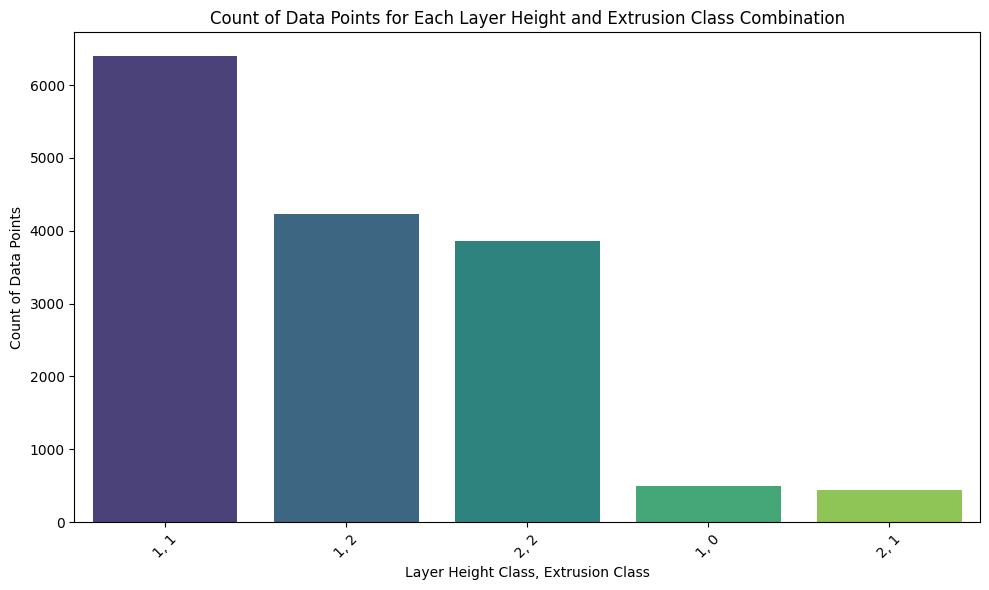

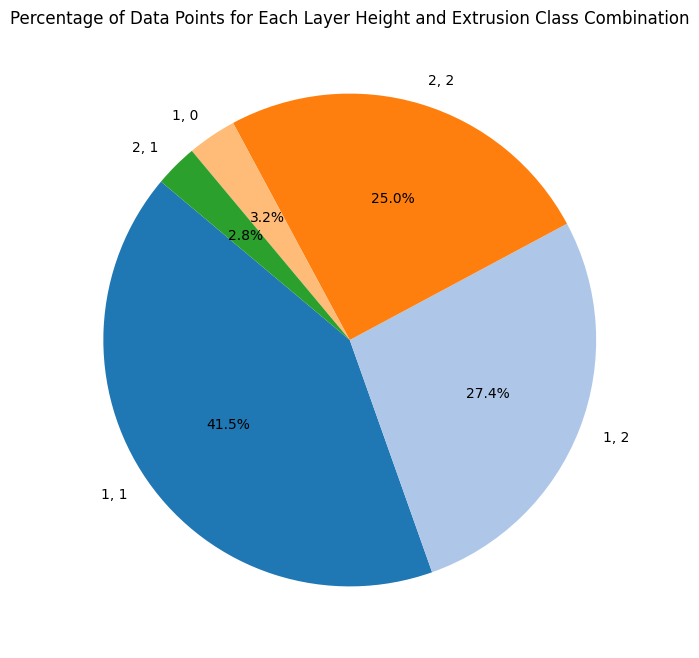

In [3]:
#Visualise the labels
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
file_path = r'C:\Users\Swornava\Delft University of Technology\Wei Wei - MSc3_CORE_Group 2\Dataset\mudtracker3D_dataset\FINAL_\final_dataset_full_filtered.csv'
data = pd.read_csv(file_path)

# Create a new column combining layer_height_class and extrusion_class for unique identifiers
data['class_combination'] = data['layer_height_class'].astype(str) + ", " + data['extrusion_class'].astype(str)

# Group by the combination and count occurrences
comb_counts = data['class_combination'].value_counts().reset_index()
comb_counts.columns = ['class_combination', 'count']

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='class_combination', y='count', data=comb_counts, palette='viridis')
plt.title('Count of Data Points for Each Layer Height and Extrusion Class Combination')
plt.xlabel('Layer Height Class, Extrusion Class')
plt.ylabel('Count of Data Points')
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

# Define a color palette with unique colors
colors = sns.color_palette('tab20', len(comb_counts))

# Plot a pie chart with unique colors
plt.figure(figsize=(8, 8))
plt.pie(comb_counts['count'], labels=comb_counts['class_combination'], autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Percentage of Data Points for Each Layer Height and Extrusion Class Combination')
plt.show()




In [4]:
import os

# Define the folder path
folder_path = r'C:\Users\Swornava\Delft University of Technology\Wei Wei - MSc3_CORE_Group 2\Test_print\test_print_photo\Image_detection'

# List all files in the folder
files = sorted(os.listdir(folder_path))

# Loop through each file and rename it
for i, filename in enumerate(files, start=1):
    # Split the file name and extension
    file_ext = os.path.splitext(filename)[1]
    # Create the new filename with the incremented number
    new_name = f"{i}{file_ext}"
    # Full path for original and new names
    old_file = os.path.join(folder_path, filename)
    new_file = os.path.join(folder_path, new_name)
    # Rename the file
    os.rename(old_file, new_file)

print("Files have been renamed successfully.")

Files have been renamed successfully.


Remove test samples:

In [2]:
import os
import pandas as pd
import shutil
import random

# Define paths
original_csv_path = r'C:\Users\Swornava\Delft University of Technology\Wei Wei - MSc3_CORE_Group 2\Dataset\mudtracker3D_dataset\Test- only A1 data\final_dataset_full_filtered.csv'
source_folder = r'C:\Users\Swornava\Delft University of Technology\Wei Wei - MSc3_CORE_Group 2\Dataset\mudtracker3D_dataset\Test- only A1 data\dataset_filtered'
destination_folder = r'C:\Users\Swornava\Delft University of Technology\Wei Wei - MSc3_CORE_Group 2\Dataset\mudtracker3D_dataset\Test- only A1 data\subset_30imagesfrom each sample\dataset_filtered'

# Create destination folder if it doesn't exist
os.makedirs(destination_folder, exist_ok=True)

# Load the CSV file
df = pd.read_csv(original_csv_path)

# List of required types
required_types = [
    "A0a", "A1a", "A1d", "A1e", "A1f", "A1g", "A1h", "A1i", "A1j", "A1k", 
    "A1l", "A1m", "A2a", "A2b", "A2c", "A3a", "A4a", "A5a", "B0a", "B1a", "B2a", "B3a", "B4a", "B5a", "B6a", "B7a", 
    "C2a", "C3a", "C3b", "C3c", "C4a", "C4b", "C4c", "C4d", "C5a", "C5b", "C5c", "C6b", "C7a", "D3a", "D3b", "D3c", "D4a", "D4b", "D5a", "D6a", "D7a", "D8a"
]

# Filter and move images
removed_df = pd.DataFrame(columns=df.columns)
remaining_df = df.copy()

for img_type in required_types:
    # Filter images of the specific type
    filtered_images = df[df['img_path'].str.contains(f'/{img_type}_')]
    
    # Select 3 random images if available
    if len(filtered_images) >= 30:
        sampled_images = filtered_images.sample(n=30, random_state=1)
        
        # Move each sampled image
        for img_path in sampled_images['img_path']:
            src_path = os.path.join(source_folder, os.path.basename(img_path))
            dst_path = os.path.join(destination_folder, os.path.basename(img_path))
            if os.path.exists(src_path):
                shutil.move(src_path, dst_path)
        
        # Update DataFrames
        removed_df = pd.concat([removed_df, sampled_images])
        remaining_df = remaining_df[~remaining_df['img_path'].isin(sampled_images['img_path'])]

# Save the updated CSV files
removed_csv_path = r'C:\Users\Swornava\Delft University of Technology\Wei Wei - MSc3_CORE_Group 2\Dataset\mudtracker3D_dataset\Test- only A1 data\subset_30imagesfrom each sample\removed_images.csv'
remaining_csv_path = r'C:\Users\Swornava\Delft University of Technology\Wei Wei - MSc3_CORE_Group 2\Dataset\mudtracker3D_dataset\Test- only A1 data\subset_30imagesfrom each sample\remaining_images.csv'

removed_df.to_csv(removed_csv_path, index=False)
remaining_df.to_csv(remaining_csv_path, index=False)

print("Images moved and CSV files updated successfully.")


C:\Users\Swornava\AppData\Local\Temp\ipykernel_26408\2141282843.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  removed_df = pd.concat([removed_df, sampled_images])


Images moved and CSV files updated successfully.
